In [76]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
from torch.utils.data import random_split
import os
import torch
import torch.nn as nn
from torchvision import models


In [77]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [78]:

class CustomDataset(Dataset):
    
    def __init__(self, image_patches_csv, images_dir, transform=None):
        self.image_patches_df = pd.read_csv(image_patches_csv)
        self.images_dir = images_dir
        self.transform = transform

        # Filter out invalid entries
        self.valid_samples = []
        
        for index, row in self.image_patches_df.iterrows():
            img_id = row['ID'].replace('.', '/') 
            img_path = os.path.join(self.images_dir, img_id + '.png')

            # Check if the image exists and the 'Presence' is not 0
            if os.path.exists(img_path) and row['Presence'] != 0:
                label = row['Presence']
                # Convert labels from -1/1 to 0/1 for CrossEntropyLoss
                label = 0 if label == -1 else 1
                self.valid_samples.append((img_path, label))                             
        
    def __len__(self):
        return len(self.valid_samples)

    def __getitem__(self, idx):
        image_path, label = self.valid_samples[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def __proba__(self):
        return(self.valid_entries) 


In [79]:
image_patches_csv = "C:/Users/alexx/OneDrive/Escriptori/window_metadata.csv" 
image_patches_df = pd.read_csv(image_patches_csv)
images_dir = "C:/Users/alexx/OneDrive/Escriptori/AnnotatedPatches/AnnotatedPatches/"
valid_entries = []
test_slze=219

for index, row in image_patches_df.iterrows():
    # Construct the image ID with directory and file extension
    img_id = row['ID'].replace('.', '/') 
    img_path = os.path.join(images_dir, img_id + '.png')


    # Check if the image exists and the 'Presence' is not 0
    if os.path.exists(img_path) and row['Presence'] != 0:
        valid_entries.append(img_path)


print(len(valid_entries))

# "C:\Users\alexx\OneDrive\Escriptori\AnnotatedPatches\AnnotatedPatches\B22-101_0\00180.png"                                 

1254


In [80]:
a = os.path.exists('C:/Users/alexx/OneDrive/Escriptori/AnnotatedPatches/AnnotatedPatches/B22-101_0/00180.png')
print(a)

True


In [81]:
image_patches_csv = "C:/Users/alexx/OneDrive/Escriptori/window_metadata.csv" 
images_dir = "C:/Users/alexx/OneDrive/Escriptori/AnnotatedPatches/AnnotatedPatches/"
transforms = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomRotation(15), transforms.Resize((224, 224)), transforms.ToTensor()])

custom_dataset = CustomDataset(image_patches_csv=image_patches_csv, images_dir=images_dir, transform=transforms)



In [82]:
# Dividing into Training and testing.

train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [83]:
# Load a pretrained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freezeing the features layers because we do not want to re-train them just use with the weights already learnt.
for param in vgg16.features.parameters():
    param.requires_grad = False


# We remove last layer and create a new Linear layer that we want to train with our own features.
num_features = vgg16.classifier[6].in_features # We want to know the numbr of features the model had initially to construct correctly our new layer.
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Dropout(p=0.5), nn.Linear(num_features, 2)]) # Add our layer with 2 outputs, because we have two classes pylori (1) or no pylory(-1). Add also dropout
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier.

c:\Users\alexx\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alexx\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [84]:


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.classifier.parameters(), lr=0.001)

# Function to train the model
def train_model(model, criterion, optimizer, train_loader, num_epochs = 12):
    loss_history = []
    for epoch in range(num_epochs):
        model.train()  
        
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        loss_history.append(epoch_loss)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Epoch {epoch}/{num_epochs - 1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, loss_history


In [85]:

vgg16 = vgg16.to(device)

# Train the model
vgg16, loss_history = train_model(vgg16, criterion, optimizer, train_loader, num_epochs=11)



Epoch 0/10 Loss: 0.9821 Acc: 0.7886
Epoch 1/10 Loss: 0.6209 Acc: 0.8335
Epoch 2/10 Loss: 0.5082 Acc: 0.8485
Epoch 3/10 Loss: 0.4081 Acc: 0.8634
Epoch 4/10 Loss: 0.4671 Acc: 0.8644
Epoch 5/10 Loss: 0.4738 Acc: 0.8624
Epoch 6/10 Loss: 0.5208 Acc: 0.8514
Epoch 7/10 Loss: 0.3740 Acc: 0.8843
Epoch 8/10 Loss: 0.4324 Acc: 0.8843
Epoch 9/10 Loss: 0.3457 Acc: 0.8983
Epoch 10/10 Loss: 0.2898 Acc: 0.9123


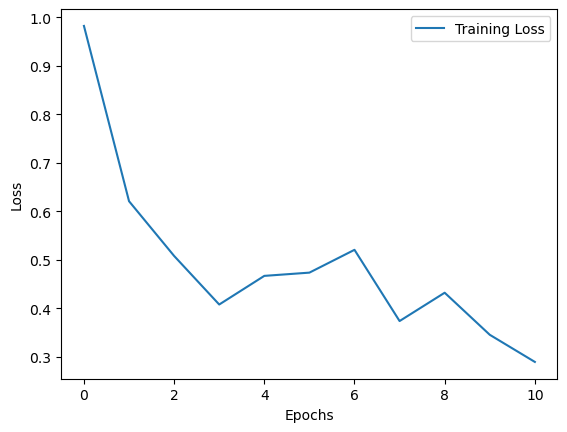

In [86]:
import matplotlib.pyplot as plt
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [87]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Function to get predictions and true labels
def get_all_preds_labels(model, data_loader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds = torch.cat((all_preds, preds.cpu()), dim=0)
            all_labels = torch.cat((all_labels, labels.cpu()), dim=0)
            
    return all_preds.numpy(), all_labels.numpy()

preds, labels = get_all_preds_labels(vgg16, test_loader)

conf_matrix = confusion_matrix(labels, preds)


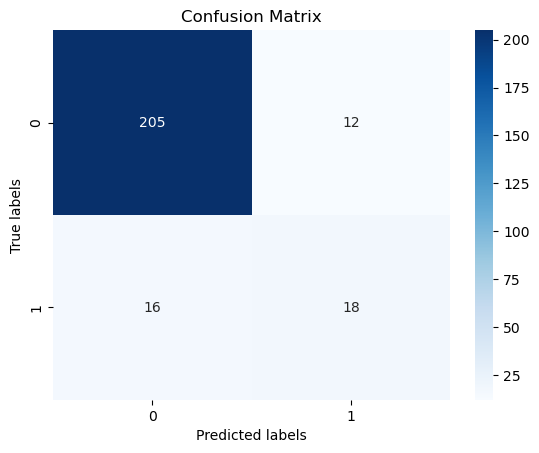

In [88]:
import seaborn as sns

sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlOrRd')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
